In [1]:
import os, random                                                                   # for handelling the files
import numpy as np                                                                  # working with arrays and data manupilation
import pandas as pd
import json
import matplotlib.pyplot as plt                                                     # plottting                

from glob import glob                                                               # for handelling file paths
from pathlib import Path                                                            # for handelling file paths
from natsort import natsorted                                                       # for sorting files
from tqdm.auto import tqdm                                                          # for asthetic for loops :)
from collections import Counter                                                     # drawing charts
import seaborn as sns

from sklearn.model_selection import train_test_split                                # splitting the dataset
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import confusion_matrix, accuracy_score

In [2]:
import torch, torchvision, torchmetrics, torchinfo
import torch.optim as optim                                                         # optimizer
import torch.nn.functional as F                                                     # loss function

from torch import nn                                                                # building neural networks
from torch.utils.data import Dataset                                                # building dataset objects
from torch.utils.data import DataLoader                                             # building data loaders to feed the data to model
from torch.utils.tensorboard import SummaryWriter                                   # for tracking model performance(easy to use)
from torchvision import transforms                                                  # for changes to the dataset content
from torchinfo import summary                                                       # gives a summery of model structure

In [3]:
import cv2                                                                          # for opening the video files
import mediapipe as mp                                                              # for detecting landmarks

In [4]:
if torch.cuda.is_available():
    print("Cuda is available.")
    print(f"Current Device: {torch.cuda.current_device()}, Device Name: {torch.cuda.get_device_name(torch.cuda.current_device())}")

Cuda is available.
Current Device: 0, Device Name: NVIDIA GeForce RTX 3060 Laptop GPU


In [5]:
root= 'WLASLdataset_100/WLASL100/'
save_directory= 'WLASLdataset_100/'
class_names = ["accident", "africa", "all", "apple", "basketball", "bed", "before", "bird", "birthday",
                "black", "blue", "bowling", "brown", "but", "can", "candy", "chair", "change", "cheat", "city",
                "clothes", "color", "computer", "cook", "cool", "corn", "cousin", "cow", "dance", "dark",
                "deaf", "decide", "doctor", "dog", "drink", "eat", "enjoy", "family", "fine", "finish",
                "fish", "forget", "full", "give", "go", "graduate", "hat", "hearing", "help", "hot",
                "how", "jacket", "kiss", "language", "last", "letter", "like", "man", "many", "meet",
                "mother", "need", "no", "now", "orange", "paint", "paper", "pink", "pizza", "play",
                "pull", "purple", "right", "same", "school", "secretary", "shirt", "short", "son", "study",
                "table", "tall", "tell", "thanksgiving", "thin", "thursday", "time", "walk", "want", "what",
                "white", "who", "woman", "work", "wrong", "year", "yes", "book", "later", "medicine"]

In [6]:
def process_frame(cap, index):
    cap.set(cv2.CAP_PROP_POS_FRAMES, index)
    return cap.read() 

In [7]:
def interpolate_detections(most_recent_detection, next_coming_detection, alpha):
    if most_recent_detection is None and next_coming_detection is not None:       # this handels the case when the first frame is corrupt
        return next_coming_detection
    elif most_recent_detection is not None and next_coming_detection is None:
        return most_recent_detection
    else:
        return (1 - alpha) * most_recent_detection + alpha * next_coming_detection

In [8]:
def fill_empty_detections(result):
    detections= result
    for video_detection in detections:
        most_recent_detection= None
        for i in range(len(video_detection)):
            if len(video_detection[i]) != 0:
                most_recent_detection= video_detection[i]
            else:
                next_coming_detection= None
                for j in range(i+1, len(video_detection)):
                    if len(video_detection[j]) != 0:
                        next_coming_detection= video_detection[j]
                        break
                    else:
                        continue
                     
                video_detection[i]= interpolate_detections(most_recent_detection, next_coming_detection, 0.5)
                most_recent_detection= video_detection[i]

    return detections

In [9]:
def get_landmarks(root: str, class_names, frame_numbers= 25):
    all_video_paths= natsorted([str(p) for p in Path(root).glob("**/*.mp4")])
    vid_idx_to_class_name= {i+1:label for i, label in enumerate(class_names)}
    none_cv2_video_paths= []                                # keeping track of corrupt video files
    detections= []                                          # saves mediapipe detections
    labels= []
    
    with mp.solutions.holistic.Holistic(min_detection_confidence= 0.5, min_tracking_confidence=0.5) as holistic:
        for video_path in tqdm(all_video_paths, desc="Processing videos"):
            cap = cv2.VideoCapture(video_path)              # Read each video using cv2
            if not cap.isOpened():                          # if cv2 can't read the video
                none_cv2_video_paths.append(video_path)     # save the video path
                continue
                
            total_frames_number = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))                                             # getting the total frames in video
            frame_idxs_to_process = np.round(np.linspace(0, total_frames_number - 1, frame_numbers)).astype(int)     # picking desiered frame indexes
            video_detections= []
            for idx in frame_idxs_to_process:
                ret, frame= process_frame(cap, idx)

                # if the return value is False: meaning the frame was "bad" then we try to read the before and after frames with cv2.
                if ret is False:
                    print(f"Failed to grab frame {idx}, of video {video_path} of length {total_frames_number} frames. trying adjacent frames...")
                    
                    ret, frame = grab_frame(cap, idx - 1)
                    if not ret:
                        ret, frame = grab_frame(cap, idx + 1)
                        
                # if the return value is False: meaning the frame was "bad" then we try to read the before and after frames with cv2.
                if not ret:
                    print(f"Unable to retrieve any frames around index {idx}, of video {video_path} of length {total_frames_number} frames.")
                    detection= []
                    video_detections.append(detection)
                    continue
                            
                result= holistic.process(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
                pose= np.array([[res.x, res.y, res.z, res.visibility] for res in result.pose_landmarks.landmark]).flatten() if result.pose_landmarks else np.zeros(33*4) 
                face= np.array([[res.x, res.y, res.z] for res in result.face_landmarks.landmark]).flatten() if result.face_landmarks else np.zeros(468*3) 
                lh= np.array([[res.x, res.y, res.z] for res in result.left_hand_landmarks.landmark]).flatten() if result.left_hand_landmarks else np.zeros(21*3)
                rh= np.array([[res.x, res.y, res.z] for res in result.right_hand_landmarks.landmark]).flatten() if result.right_hand_landmarks else np.zeros(21*3)
                detection= np.concatenate((pose,face,lh, rh))
                video_detections.append(detection)

                
            detections.append(video_detections)    
            label= vid_idx_to_class_name[int(os.path.basename(os.path.dirname(video_path)))]
            labels.append(label)
   
        cap.release()
        
    return detections, labels, len(all_video_paths),len(none_cv2_video_paths)

In [10]:
#result = get_landmarks(root, class_names)

In [11]:
#detections= fill_empty_detections(result[0])

In [12]:
#np.save(os.path.join(save_directory, 'detections.npy'), np.array(detections))     # saving detection 
#with open(os.path.join(save_directory, 'labels.json'), 'w') as file:
#    json.dump(result[1], file)                                                   # saving labels

In [13]:
detections= np.load(os.path.join(save_directory, 'detections.npy'), allow_pickle=True)
with open(os.path.join(save_directory, 'labels.json'), 'r') as file:
    labels= json.load(file)

# Preparing data

In [51]:
from sklearn.utils import resample

def bootstrapping(X_train, y_train, n_bootstraps=10):
    # Initialize empty arrays to hold the concatenated data and labels
    bootstrapped_X = np.empty((0,) + X_train.shape[1:])
    bootstrapped_y = np.empty((0,))

    # Generate bootstrapped datasets and concatenate them
    for _ in range(n_bootstraps):
        X_sample, y_sample = resample(X_train, y_train, replace=True)
        bootstrapped_X = np.vstack((bootstrapped_X, X_sample))
        bootstrapped_y = np.concatenate((bootstrapped_y, y_sample))
    
    return bootstrapped_X, bootstrapped_y

In [71]:
label_map= {label: num for num, label in enumerate(class_names)}

X_train, X_test, y_train, y_test = train_test_split(detections, labels, test_size=0.4, random_state=42, stratify=labels)
augmented_X_train, augmented_y_train = bootstrapping(X_train, y_train, n_bootstraps=10)

augmented_X_train, X_test= torch.tensor(augmented_X_train, dtype=torch.float32) , torch.tensor(X_test, dtype=torch.float32)

augmented_y_train= [label_map[label] for label in augmented_y_train]
y_test= [label_map[label] for label in y_test]
augmented_y_train= torch.tensor(augmented_y_train, dtype=torch.long)
y_test= torch.tensor(y_test, dtype=torch.long)



augmented_X_train.shape, X_test.shape, augmented_y_train.shape, y_test.shape

(torch.Size([8380, 25, 1662]),
 torch.Size([560, 25, 1662]),
 torch.Size([8380]),
 torch.Size([560]))

In [15]:
class CustomDataset(Dataset):
    def __init__(self,features, labels):
        self.features = features
        self.labels = labels
        
    def __len__(self):
        return len(self.labels)
        
    def __getitem__(self, index):
        feature = self.features[index]
        label = self.labels[index]
        return feature, label

In [72]:
train_dataset= CustomDataset(augmented_X_train, augmented_y_train)
test_dataset= CustomDataset(X_test, y_test)

In [73]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [55]:
class LstmModel1(nn.Module):
    def __init__(self, input_size=1662, hidden_size=100, num_classes=100):
        super().__init__()
        self.lstm1 = nn.LSTM(input_size=input_size, hidden_size=hidden_size, batch_first=True)
        
        # Define the Dense layers
        self.dense1 = nn.Linear(hidden_size, hidden_size)
        self.dense2 = nn.Linear(hidden_size, num_classes)  # Output layer for num_classes

        # Define activation functions
        self.relu = nn.ReLU()

    def forward(self, x):
        x, (hn, cn) = self.lstm1(x)
        x = x[:, -1, :]  # Selecting the last time step's output for classification

        x = self.relu(self.dense1(x))
        x = self.dense2(x)  # Final classification layer
        return x

In [56]:
test_model= LstmModel1().to(device)
summary(test_model, input_size=(1, 25, 1662)) # summery of the model's structure

Layer (type:depth-idx)                   Output Shape              Param #
LstmModel1                               [1, 100]                  --
├─LSTM: 1-1                              [1, 25, 100]              705,600
├─Linear: 1-2                            [1, 100]                  10,100
├─ReLU: 1-3                              [1, 100]                  --
├─Linear: 1-4                            [1, 100]                  10,100
Total params: 725,800
Trainable params: 725,800
Non-trainable params: 0
Total mult-adds (M): 17.66
Input size (MB): 0.17
Forward/backward pass size (MB): 0.02
Params size (MB): 2.90
Estimated Total Size (MB): 3.09

In [57]:
class TransformerModelP(nn.Module):
    def __init__(self, num_classes= 100, seq_len=25, landmarks=1662, hidden_dim=128, nhead=4, num_layers=2):
        super().__init__()

        self.seq_len = seq_len
        self.landmarks = landmarks
        self.input_proj = nn.Linear(landmarks, hidden_dim)
        self.pos_encoder = nn.Parameter(torch.randn(1, seq_len, hidden_dim))
        
        encoder_layer = nn.TransformerEncoderLayer(d_model=hidden_dim, nhead=nhead, batch_first=True)
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        
        self.linear_class = nn.Linear(hidden_dim, num_classes)

    def forward(self, inputs):
        batch_size, seq_len, _ = inputs.shape
        inputs_proj = self.input_proj(inputs.view(batch_size * seq_len, -1)).view(batch_size, seq_len, -1)
        
        # Adding positional encodings
        inputs_encoded = inputs_proj + self.pos_encoder
        
        # Passing through the transformer encoder
        transformer_output = self.transformer_encoder(inputs_encoded)
        
        # Using only the output from the last time step for classification
        output = self.linear_class(transformer_output[:, -1, :])
        
        return output

In [58]:
test_model = TransformerModelP().to(device)
summary(test_model, input_size=(1, 25, 1662))

Layer (type:depth-idx)                        Output Shape              Param #
TransformerModelP                             [1, 100]                  3,200
├─Linear: 1-1                                 [25, 128]                 212,864
├─TransformerEncoder: 1-2                     [1, 25, 128]              --
│    └─ModuleList: 2-1                        --                        --
│    │    └─TransformerEncoderLayer: 3-1      [1, 25, 128]              593,024
│    │    └─TransformerEncoderLayer: 3-2      [1, 25, 128]              593,024
├─Linear: 1-3                                 [1, 100]                  12,900
Total params: 1,415,012
Trainable params: 1,415,012
Non-trainable params: 0
Total mult-adds (M): 5.33
Input size (MB): 0.17
Forward/backward pass size (MB): 0.03
Params size (MB): 0.90
Estimated Total Size (MB): 1.10

In [59]:
def train(num_epochs, model, train_dataloader, test_dataloader, optimizer, criterion, calculate_accuracy, device):
    train_losses, test_losses, train_accuracies, test_accuracies= [], [], [], []
 
    for epoch in tqdm(range(num_epochs), desc="Training Epoch"):
        model.train()
        train_loss, train_accuracy = 0.0, 0.0

        for inputs, labels in train_dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item()
            train_accuracy += calculate_accuracy(outputs, labels)
        
        train_losses.append(train_loss / len(train_dataloader))
        train_accuracies.append(train_accuracy / len(train_dataloader))
    
        model.eval()
        all_preds, all_labels= [], []
        test_loss, test_accuracy= 0.0, 0.0
        
        with torch.no_grad():
            for inputs, labels in test_dataloader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                
                loss = criterion(outputs, labels)
                test_loss += loss.item()
                test_accuracy += calculate_accuracy(outputs, labels)
                
                _, preds = torch.max(outputs, 1)                  # Get the predicted labels
                all_preds.extend(preds.view(-1).cpu().numpy())    # Store predictions
                all_labels.extend(labels.view(-1).cpu().numpy())  # Store true labels
                
        
        test_losses.append(test_loss / len(test_dataloader))
        test_accuracies.append(test_accuracy / len(test_dataloader))
        #print(f'Epoch {epoch+1}, Train Loss: {train_losses[-1]}, Test Loss: {test_losses[-1]}, Train Accuracy: {train_accuracies[-1]}, Test Accuracy: {test_accuracies[-1]}')

    return train_losses, test_losses, train_accuracies, test_accuracies, all_preds, all_labels

In [60]:
def calculate_accuracy(y_pred, y_true):
    _, predictions = torch.max(y_pred, 1)
    correct = (predictions == y_true).float()
    accuracy = correct.sum() / len(correct)
    return accuracy

In [61]:
def draw_loss_accuracy(train_losses, test_losses, train_accuracies, test_accuracies, batch_size):
    train_accuracies_cpu = [x.cpu().item() for x in train_accuracies] 
    test_accuracies_cpu = [x.cpu().item() for x in test_accuracies]
    
    plt.figure(figsize=(14, 7))
    
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Training Loss')  # or use train_losses_cpu if converted
    plt.plot(test_losses, label='Validation Loss')  # or use test_losses_cpu if converted
    plt.title(f'Loss over Epochs(batch size= {batch_size})')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    
    plt.subplot(1, 2, 2)
    plt.plot(train_accuracies_cpu, label='Training Accuracy')
    plt.plot(test_accuracies_cpu, label='Validation Accuracy')
    plt.title('Accuracy over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    
    plt.tight_layout()
    plt.show()

In [62]:
def draw_confmatrix(all_labels, all_preds, class_names, num_epochs):
    conf_matrix = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(18, 15))
    sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title(f'Confusion Matrix after {num_epochs} epoches')
    plt.show()

In [64]:
num_epochs= 1000
batch_size= 128
learning_rate= 0.0001

lstm_model= LstmModel1().to(device)                                   # initialize model

train_dataloader = DataLoader(dataset=train_dataset, batch_size= batch_size, num_workers=0, shuffle=True) 
test_dataloader = DataLoader(dataset=test_dataset, batch_size= batch_size, num_workers=0, shuffle=False) 
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(lstm_model.parameters(), lr= learning_rate)

train_losses, test_losses, train_accuracies, test_accuracies, all_preds, all_labels = train(num_epochs, lstm_model, train_dataloader, test_dataloader, optimizer, criterion, calculate_accuracy, device)

Training Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

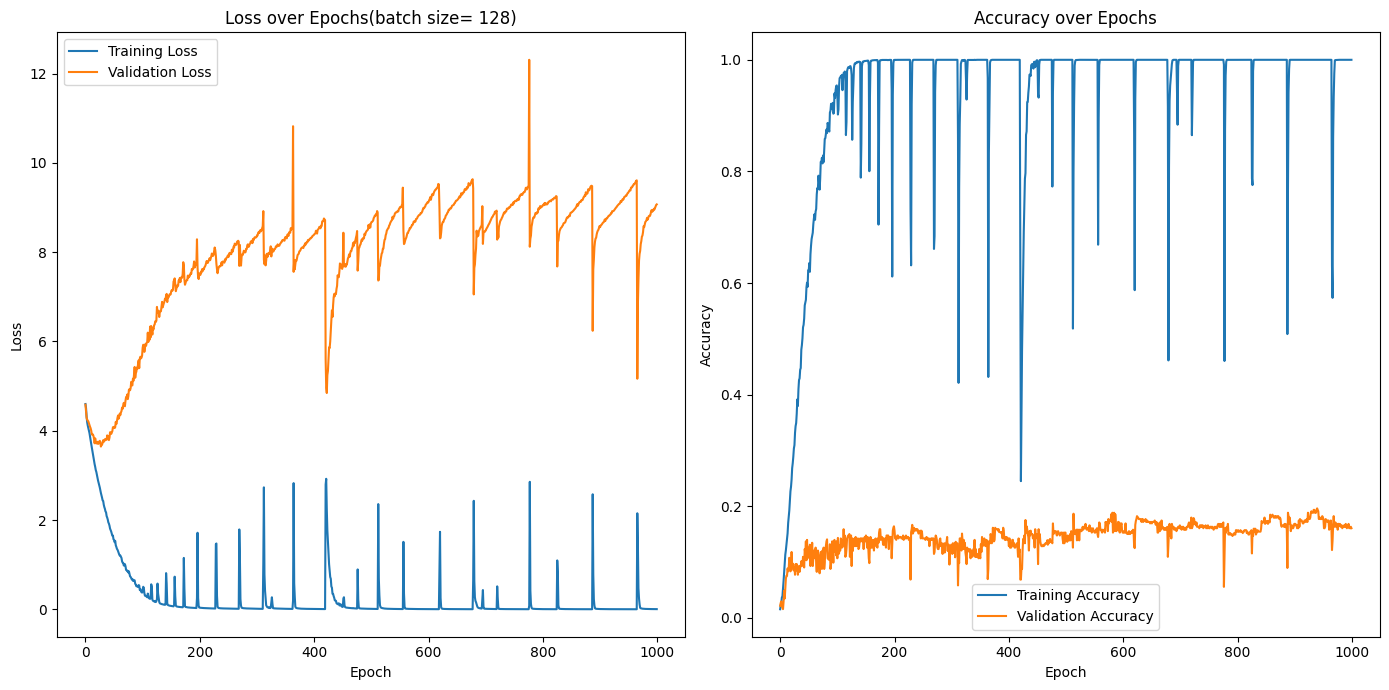

In [65]:
draw_loss_accuracy(train_losses, test_losses, train_accuracies, test_accuracies, batch_size)

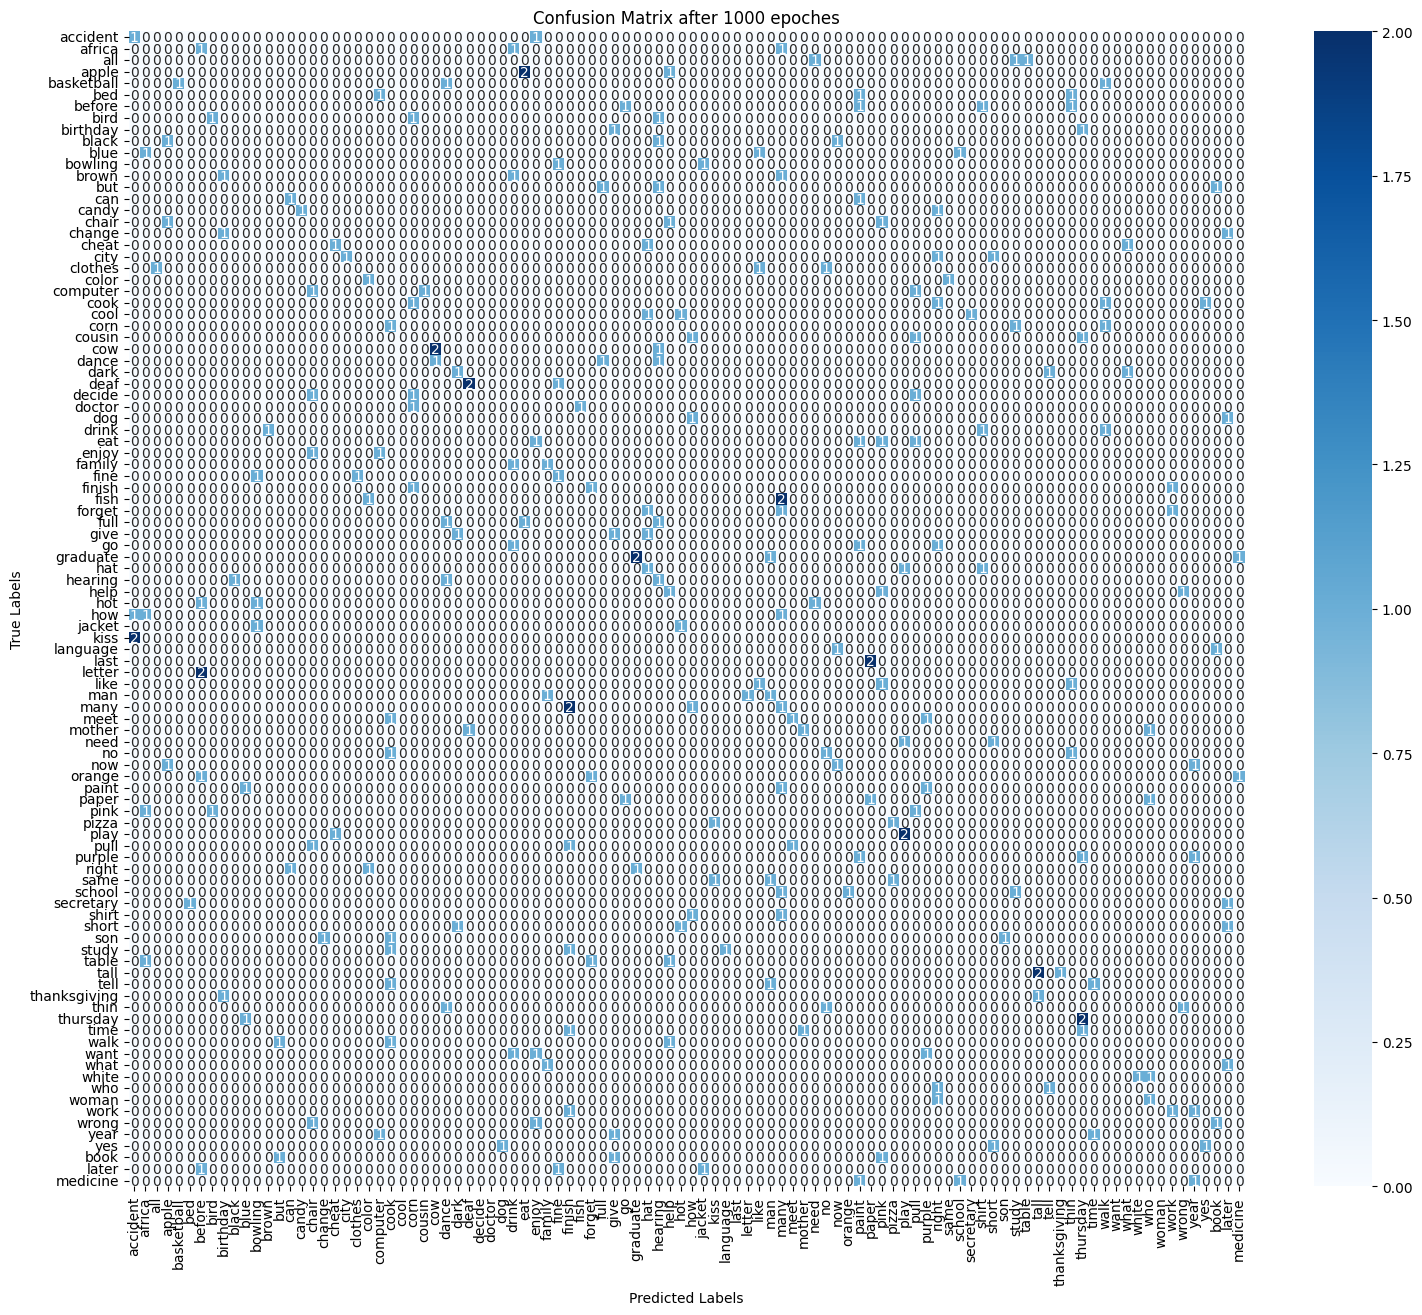

In [66]:
draw_confmatrix(all_labels, all_preds, class_names, num_epochs)

In [74]:
num_epochs= 100
batch_size= 128
learning_rate= 0.0001

transformer_modelp= TransformerModelP().to(device)                  # initialize 

train_dataloader = DataLoader(dataset=train_dataset, batch_size= batch_size, num_workers=0, shuffle=True) 
test_dataloader = DataLoader(dataset=test_dataset, batch_size= batch_size, num_workers=0, shuffle=False) 
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(transformer_modelp.parameters(), lr= learning_rate)

train_losses, test_losses, train_accuracies, test_accuracies, all_preds, all_labels = train(num_epochs, transformer_modelp, train_dataloader, test_dataloader, optimizer, criterion, calculate_accuracy, device)

Training Epoch:   0%|          | 0/100 [00:00<?, ?it/s]

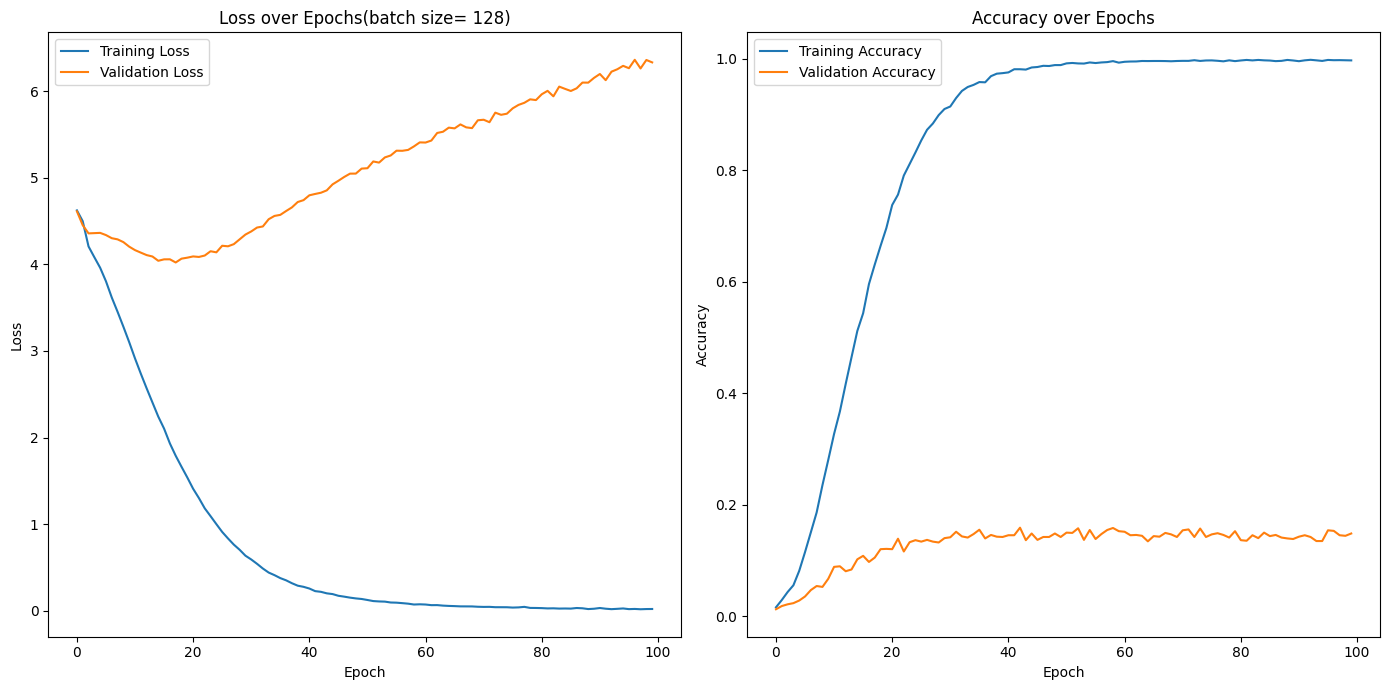

In [75]:
draw_loss_accuracy(train_losses, test_losses, train_accuracies, test_accuracies, batch_size)

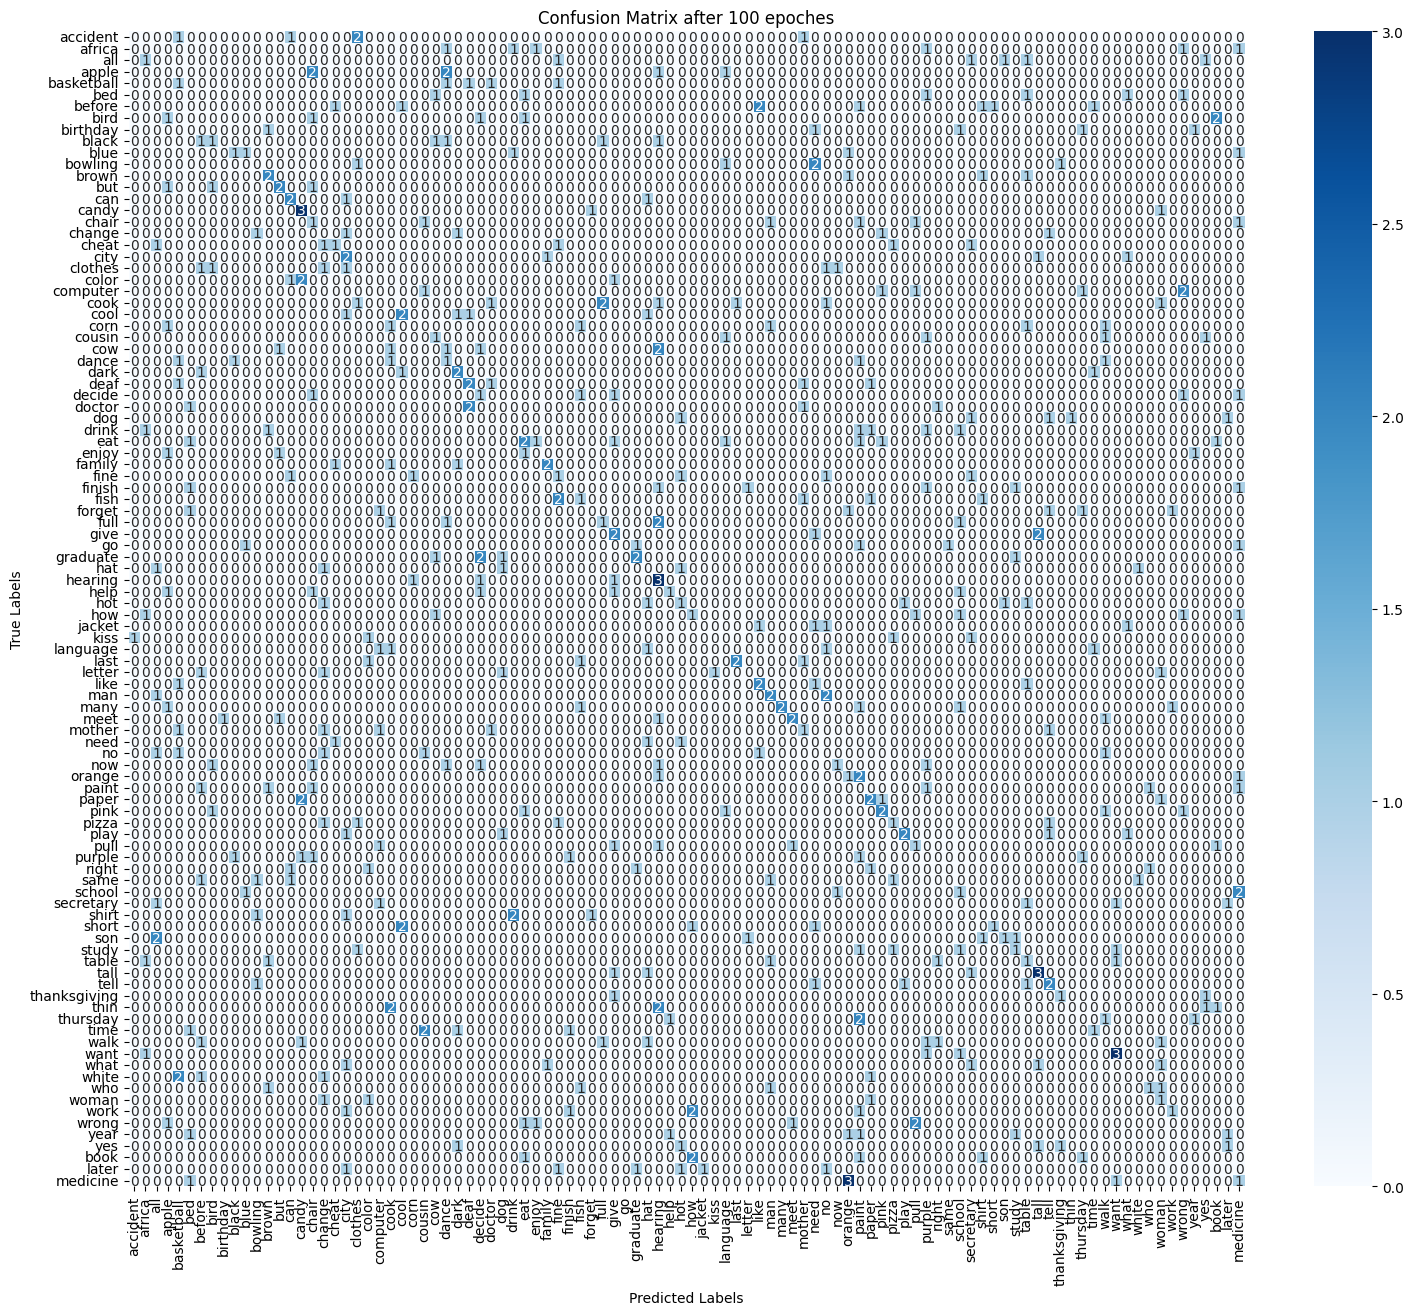

In [76]:
draw_confmatrix(all_labels, all_preds, class_names, num_epochs)